## Background
Previously, I modeled a "heat box", but ignored the effects of the sun. As anyone who has had to get into a car that has sat outside for a while on a hot summer day, the inside of the car is warmer than the outside air temperature, and my previous model didn't allow that. So the sun is important.  Consider the following information from [The Humane Society](https://www.humanesociety.org/resources/what-do-if-you-see-pet-parked-car).

> It doesn't have to be that warm outside for a car to become dangerously hot inside.
>
> - When it's 72 degrees Fahrenheit outside, the temperature inside your car can heat up to 116 degrees Fahrenheit within an hour.
> - When it's 80 degrees Fahrenheit outside, the temperature inside your car can heat up to 99 degrees Fahrenheit within 10 minutes.
> - Rolling down the windows has been shown to have little effect on the temperature inside a car.

Let's translate these temperatures to Celsius and Kelvin

- When it's 22 degrees Celsius (295 K) outside, the temperature inside your car can heat up to 47 degrees Celsius (320 K) within an hour.
- When it's 27 degrees Celsius (300 K) outside, the temperature inside your car can heat up to 37 degrees Celsius (310 K) within 10 minutes.

My plan for this post is to assume that my heat box will heat up similarly to the above generic car, and see what sort of parameters I need to make that work.

## Previous work
As before, I'll model the system as a simple box, however, this time it will be car-sized, and I'll use thermal properties that are common for metals like aluminum

In [1]:
import numpy as np

# Heat parameters
thermalDiffusivity = 22.39e-6 # meters^2/s for air
heatTransferCoef = 1 # For a typical metal to air W/m^2K
thermalConductivity = 50 # For a typical metal W/mK
specificHeat = 1000 # for aluminum J/kg K
wallDensity = 3000 # kg/m^3 for aluminum
wallThickness = 0.002 # m
solarIntensity = 1000 # W/m^2

# Length parameters (meters)
L = 3
W = 2
H = 1.5

Deltax = 0.05
xmax = int(L/Deltax)
ymax = int(W/Deltax)
zmax = int(H/Deltax)

xmid = xmax // 2
ymid = ymax // 2
zmid = zmax // 2

xgrid = np.linspace(0,L,xmax+1)
ygrid = np.linspace(0,W,ymax+1)
zgrid = np.linspace(0,H,zmax+1)

u0 = np.empty((xmax,ymax,zmax))

## Heat Equation
The heat equation is:

$$
\frac{\partial u}{\partial t} = \alpha \nabla^2u + \text{Internal Power Generation Term} + \text{Convection on the boundary}
$$

Where $\alpha=\frac{k}{c\rho}$ is the thermal diffusivity of the material, and $k$ is the thermal conductivity, $c$ is the specific heat, and $\rho$ is the density.

When working numerically, it is common to employ a finite mesh and determine the system temperature at discrete points in space as follows
$$
u(x,y,z,t) \rightarrow u(x_i,y_j,z_k,t) = u_{ijk}(t)
$$

### Internal Power Generation
This should be proportional to the solar intensity.  For now, I will model it as:

$$
A I_{\text{sun}} f(x,y,z)
$$

where $A$ is a constant that I will determine empirically. For this model, I will assume:

$$
f(x,y,z) = 
\begin{cases}
1 &z=H \\
0 &\text{else}
\end{cases}
$$

This has the meaning that for this model, the sun is directly overhead

In [2]:
def powerGen(umat, intensity, A):
    powerGen = np.zeros_like(umat)

    powerDensity = A*intensity
    powerGen[:,:,-1].fill(powerDensity)

    return powerGen

### Boundary convection

The power exchange per unit volume due to convection is proportional to the difference in temperature of air and the temperature at the boundary:

$$
B \left(T_{\text{air}}-u(x_S,y_S,z_S,t)\right)
$$
for points $(x_S,y_S,z_S)$ on the boundary of the object (assuming a uniform air temperature). Again, $B$ is a constant that I will determine empirically.


In [3]:
def bdryConv(umat, Tair, B):

    bdryTemp = np.zeros_like(umat)
    uSurf = np.zeros_like(umat)

    bdryTemp[0,:,:].fill(Tair)
    bdryTemp[:,0,:].fill(Tair)
    bdryTemp[:,:,0].fill(Tair)
    bdryTemp[-1,:,:].fill(Tair)
    bdryTemp[:,-1,:].fill(Tair)
    bdryTemp[:,:,-1].fill(Tair)

    uSurf[0,:,:] = umat[0,:,:]
    uSurf[:,0,:] = umat[:,0,:]
    uSurf[:,:,0] = umat[:,:,0]
    uSurf[-1,:,:] = umat[-1,:,:]
    uSurf[:,-1,:] = umat[:,-1,:]
    uSurf[:,:,-1] = umat[:,:,-1]

    duConvdt = B*(bdryTemp - uSurf)
    return duConvdt    

### Laplacian 

The Laplacian using the finite element analysis is:

\begin{align*}
\nabla^2 u(x,y,z,t) &\rightarrow \frac{1}{\Delta x\Delta y\Delta z} \left(\Delta y \Delta z \frac{u_{i-1,j,k}(t) + u_{i+1,j,k}(t) - 2 u_{i,j,k}(t)}{\Delta x} 
            + \Delta x \Delta z \frac{u_{i,j-1,k}(t) + u_{i,j+1,k}(t) - 2 u_{i,j,k}(t)}{\Delta y} 
            + \Delta x \Delta y \frac{u_{i,j,k-1}(t) + u_{i,j,k+1}(t) - 2 u_{i,j,k}(t)}{\Delta z}\right) \\
            &= \frac{u_{i-1,j,k}(t) + u_{i+1,j,k}(t) - 2 u_{i,j,k}(t)}{\Delta x^2} 
            + \frac{u_{i,j-1,k}(t) + u_{i,j+1,k}(t) - 2 u_{i,j,k}(t)}{\Delta y^2} 
            + \frac{u_{i,j,k-1}(t) + u_{i,j,k+1}(t) - 2 u_{i,j,k}(t)}{\Delta z^2}
\end{align*}

If we generate our grid with $\Delta x = \Delta y = \Delta z$, we obtain:

$$
\nabla^2 u_{i,j,k}(t) = \frac{u_{i-1,j,k}(t) + u_{i+1,j,k}(t) + u_{i,j-1,k}(t) + u_{i,j+1,k}(t) + u_{i,j,k-1}(t) + u_{i,j,k+1}(t) - 6 u_{i,j,k}(t)}{\Delta x^2}
$$

#### Heat Equation on a boundary *surface*
So if we are considering the $x=0, i=0$ surface:
$$
\frac{du_{0,j,k}(t)}{\partial t} = \alpha \nabla^2 u_{0,j,k}(t) + f_{0jk}(t) + \frac{h}{c\rho}(T_{\text{air}}-u_{0,j,k})
$$
where

\begin{align*}
\nabla^2 u_{0,j,k}(t) &= \frac{1}{\Delta x\Delta y\Delta z} \left(\Delta y \Delta z \frac{u_{1,j,k}(t) - u_{0,j,k}(t)}{\Delta x} 
            + \frac{\Delta x}{2} \Delta z \frac{u_{0,j-1,k}(t) + u_{0,j+1,k}(t) - 2 u_{0,j,k}(t)}{\Delta y} 
            + \frac{\Delta x}{2} \Delta y \frac{u_{0,j,k-1}(t) + u_{0,j,k+1}(t) - 2 u_{0,j,k}(t)}{\Delta z}\right) \\
    &= \frac{1}{2} \left(\frac{2 u_{1,j,k}(t) - 2 u_{1,j,k}(t)}{\Delta x^2} 
            + \frac{u_{0,j-1,k}(t) + u_{0,j+1,k}(t) - 2 u_{0,j,k}(t)}{\Delta y^2} 
            + \frac{u_{0,j,k-1}(t) + u_{0,j,k+1}(t) - 2 u_{0,j,k}(t)}{\Delta z^2}\right) \\
\end{align*}

Again, with a uniform grid, this becomes:
$$
\nabla^2 u_{0,j,k}(t) = \frac{2 u_{1,j,k}(t) + u_{0,j-1,k}(t) + u_{0,j+1,k}(t) + u_{0,j,k-1}(t) + u_{0,j,k+1}(t) - 6 u_{0,j,k}(t)}{2 \Delta x^2}
$$

Following a similar method we can find for all 6 surfaces:

\begin{align*}
\nabla^2 u_{0,j,k}(t) &= \frac{2 u_{1,j,k}(t) + u_{0,j-1,k}(t) + u_{0,j+1,k}(t) + u_{0,j,k-1}(t) + u_{0,j,k+1}(t) - 6 u_{0,j,k}(t)}{2 \Delta x^2} \\
\nabla^2 u_{I,j,k}(t) &= \frac{2 u_{I-1,j,k}(t) + u_{I,j-1,k}(t) + u_{I,j+1,k}(t) + u_{I,j,k-1}(t) + u_{I,j,k+1}(t) - 6 u_{I,j,k}(t)}{2 \Delta x^2} \\
\nabla^2 u_{i,0,k}(t) &= \frac{2 u_{i,1,k}(t) + u_{i-1,0,k}(t) + u_{i+1,0,k}(t) + u_{i,0,k-1}(t) + u_{i,0,k+1}(t) - 6 u_{i,0,k}(t)}{2 \Delta x^2} \\
\nabla^2 u_{i,J,k}(t) &= \frac{2 u_{i,J-1,k}(t) + u_{i-1,J,k}(t) + u_{i+1,J,k}(t) + u_{i,J,k-1}(t) + u_{i,J,k+1}(t) - 6 u_{i,J,k}(t)}{2 \Delta x^2} \\
\nabla^2 u_{i,j,0}(t) &= \frac{2 u_{i,j,1}(t) + u_{i-1,j,0}(t) + u_{i+1,j,0}(t) + u_{i,j-1,0}(t) + u_{i,j+1,0}(t) - 6 u_{i,j,0}(t)}{2 \Delta x^2} \\
\nabla^2 u_{i,j,K}(t) &= \frac{2 u_{i,j,K-1}(t) + u_{i,j-1,K}(t) + u_{i,j+1,K}(t) + u_{i,j,K}(t) + u_{i,j,k+1}(t) - 6 u_{i,j,K}(t)}{2 \Delta x^2} \\
\end{align*}

#### Heat equation on a boundary *edge*
So if we are considering the $x=0, i=0$, $y=0, j=0$ edge:
$$
\frac{du_{0,0,k}(t)}{\partial t} = \alpha \nabla^2 u_{0,0,k}(t) + f_{0,0,k}(t) + \frac{h}{c\rho}(T_{\text{air}}-u_{0,0,k})
$$
where

\begin{align*}
\nabla^2 u_{0,0,k}(t) &= \frac{1}{\Delta x\Delta y\Delta z} \left(\frac{\Delta y}{2} \Delta z \frac{u_{1,0,k}(t) - u_{0,0,k}(t)}{\Delta x} 
            + \frac{\Delta x}{2} \Delta z \frac{u_{0,1,k}(t) - u_{0,0,k}(t)}{\Delta y} 
            + \frac{\Delta x}{2} \frac{\Delta y}{2} \frac{u_{0,0,k-1}(t) + u_{0,0,k+1}(t) - 2 u_{0,0,k}(t)}{\Delta z}\right) \\
    &= \frac{1}{4} \left(\frac{2u_{1,0,k}(t) - 2u_{0,0,k}(t)}{\Delta x^2} 
            + \frac{2u_{0,1,k}(t) - 2u_{0,0,k}(t)}{\Delta y^2} 
            + \frac{u_{0,0,k-1}(t) + u_{0,0,k+1}(t) - 2 u_{0,0,k}(t)}{\Delta z^2}\right) \\
\end{align*}

Again, with a uniform grid, this becomes:
$$
\nabla^2 u_{0,0,k}(t) = \frac{2 u_{1,0,k}(t) +  2 u_{0,1,k}(t) + u_{0,0,k-1}(t) + u_{0,0,k+1}(t) - 6 u_{0,0,k}(t)}{4 \Delta x^2}
$$

Following a similar method we can find for all 12 edges:

\begin{align*}
    \nabla^2 u_{0,0,k}(t) &= \frac{2 u_{1,0,k}(t) +  2 u_{0,1,k}(t) + u_{0,0,k-1}(t) + u_{0,0,k+1}(t) - 6 u_{0,0,k}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{0,J,k}(t) &= \frac{2 u_{1,J,k}(t) +  2 u_{0,J-1,k}(t) + u_{0,J,k-1}(t) + u_{0,J,k+1}(t) - 6 u_{0,J,k}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{0,j,0}(t) &= \frac{2 u_{1,j,0}(t) +  2 u_{0,j,1}(t) + u_{0,j-1,0}(t) + u_{0,j+1,0}(t) - 6 u_{0,j,0}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{0,j,K}(t) &= \frac{2 u_{1,j,K}(t) +  2 u_{0,j,K-1}(t) + u_{0,j-1,K}(t) + u_{0,j+1,0}(t) - 6 u_{0,j,K}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{I,0,k}(t) &= \frac{2 u_{I-1,0,k}(t) +  2 u_{I,1,k}(t) + u_{I,0,k-1}(t) + u_{I,0,k+1}(t) - 6 u_{I,0,k}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{I,J,k}(t) &= \frac{2 u_{I-1,J,k}(t) +  2 u_{I,J-1,k}(t) + u_{I,J,k-1}(t) + u_{I,J,k+1}(t) - 6 u_{I,J,k}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{I,j,0}(t) &= \frac{2 u_{I-1,j,0}(t) +  2 u_{I,j,1}(t) + u_{I,j-1,0}(t) + u_{I,j+1,0}(t) - 6 u_{I,j,0}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{I,j,K}(t) &= \frac{2 u_{I-1,j,K}(t) +  2 u_{I,j,K-1}(t) + u_{I,j-1,K}(t) + u_{I,j+1,K}(t) - 6 u_{I,j,K}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{i,0,0}(t) &= \frac{2 u_{i,0,1}(t) +  2 u_{i,1,0}(t) + u_{i-1,0,0}(t) + u_{i+1,0,0}(t) - 6 u_{i,0,0}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{i,0,K}(t) &= \frac{2 u_{i,0,K-1}(t) +  2 u_{i,1,K}(t) + u_{i-1,0,K}(t) + u_{i+1,0,K}(t) - 6 u_{i,0,K}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{i,J,0}(t) &= \frac{2 u_{i,J,1}(t) +  2 u_{i,J-1,0}(t) + u_{i-1,J,0}(t) + u_{i+1,J,0}(t) - 6 u_{i,J,0}(t)}{4 \Delta x^2} \\
    \nabla^2 u_{i,J,K}(t) &= \frac{2 u_{i,J,K-1}(t) +  2 u_{i,J-1,K}(t) + u_{i-1,J,K}(t) + u_{i+1,J,K}(t) - 6 u_{i,J,K}(t)}{4 \Delta x^2} \\
\end{align*}

#### Heat equation on a boundary *corner*
So if we are considering the $x=0, i=0$, $y=0, j=0$, $z=0, k=0$ corner:
$$
\frac{du_{0,0,0}(t)}{\partial t} = \alpha \nabla^2 u_{0,0,0}(t) + f_{0,0,0}(t) + \frac{h}{c\rho}(T_{\text{air}}-u_{0,0,0})
$$
where

\begin{align*}
\nabla^2 u_{0,0,0}(t) &= \frac{1}{\Delta x\Delta y\Delta z} \left(\frac{\Delta y}{2} \frac{\Delta z}{2} \frac{u_{1,0,0}(t) - u_{0,0,0}(t)}{\Delta x} 
            + \frac{\Delta x}{2} \frac{\Delta z}{2} \frac{u_{0,1,0}(t) - u_{0,0,0}(t)}{\Delta y} 
            + \frac{\Delta x}{2} \frac{\Delta y}{2} \frac{u_{0,0,1}(t) - 2 u_{0,0,0}(t)}{\Delta z}\right) \\
    &= \frac{1}{4} \left(\frac{2u_{1,0,0}(t) - 2u_{0,0,0}(t)}{\Delta x^2} 
            + \frac{2u_{0,1,0}(t) - 2u_{0,0,0}(t)}{\Delta y^2} 
            + \frac{2u_{0,0,1}(t) - 2 u_{0,0,0}(t)}{\Delta z^2}\right) \\
\end{align*}

Again, with a uniform grid, this becomes:
$$
\nabla^2 u_{0,0,0}(t) = \frac{u_{1,0,0}(t) +  u_{0,1,0}(t) + u_{0,0,1}(t) - 3 u_{0,0,0}(t)}{2 \Delta x^2}
$$

Following a similar method we can find for all 8 corners:

\begin{align*}
    \nabla^2 u_{0,0,0}(t) &= \frac{u_{1,0,0}(t) +  u_{0,1,0}(t) + u_{0,0,1}(t) - 3 u_{0,0,0}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{I,0,0}(t) &= \frac{u_{I-1,0,0}(t) +  u_{I,1,0}(t) + u_{I,0,1}(t) - 3 u_{I,0,0}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{0,J,0}(t) &= \frac{u_{1,J,0}(t) +  u_{0,J-1,0}(t) + u_{0,J,1}(t) - 3 u_{0,J,0}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{0,0,K}(t) &= \frac{u_{1,0,K}(t) +  u_{0,1,K}(t) + u_{0,0,K-1}(t) - 3 u_{0,0,K}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{I,J,0}(t) &= \frac{u_{I-1,J,0}(t) +  u_{I,J-1,0}(t) + u_{I,J,1}(t) - 3 u_{I,J,0}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{I,0,K}(t) &= \frac{u_{I-1,0,K}(t) +  u_{I,1,K}(t) + u_{I,0,K-1}(t) - 3 u_{I,0,K}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{0,J,K}(t) &= \frac{u_{1,J,K}(t) +  u_{0,J-1,K}(t) + u_{0,J,K-1}(t) - 3 u_{0,J,K}(t)}{2 \Delta x^2} \\
    \nabla^2 u_{I,J,K}(t) &= \frac{u_{I-1,J,K}(t) +  u_{I,J-1,K}(t) + u_{I,J,K-1}(t) - 3 u_{I,J,K}(t)}{2 \Delta x^2} \\
\end{align*}

In [4]:
def lap3DFE(umat,dx):
    lap = np.empty_like(umat)

    # Interior elements:
    lap[1:-1,1:-1,1:-1] = (umat[:-2, 1:-1, 1:-1] + umat[2:, 1:-1, 1:-1] + umat[1:-1, :-2, 1:-1] + 
                           umat[1:-1, 2:, 1:-1] + umat[1:-1,1:-1,:-2] + umat[1:-1,1:-1,2:] - 6*umat[1:-1,1:-1,1:-1]) / dx**2

    # Surface elements:
    lap[0,1:-1,1:-1] = (2* umat[1, 1:-1, 1:-1] + 
                        umat[0, :-2, 1:-1] + umat[0, 2:, 1:-1] + umat[0, 1:-1, :-2] + umat[0, 1:-1, 2:] - 6*umat[0, 1:-1, 1:-1]) / (2*dx**2)
    lap[-1,1:-1,1:-1] = (2* umat[-2, 1:-1, 1:-1] + 
                        umat[-1, :-2, 1:-1] + umat[-1, 2:, 1:-1] + umat[-1, 1:-1, :-2] + umat[-1, 1:-1, 2:] - 6*umat[-1, 1:-1, 1:-1]) / (2*dx**2)
    lap[1:-1,0,1:-1] = (2* umat[1:-1, 1, 1:-1] + 
                        umat[:-2, 0, 1:-1] + umat[2:, 0, 1:-1] + umat[1:-1, 0, :-2] + umat[1:-1, 0, 2:] - 6*umat[1:-1, 0, 1:-1]) / (2*dx**2)
    lap[1:-1,-1,1:-1] = (2* umat[1:-1, -2, 1:-1] + 
                        umat[:-2, -1, 1:-1] + umat[2:, -1, 1:-1] + umat[1:-1, -1, :-2] + umat[1:-1, -1, 2:] - 6*umat[1:-1, -1, 1:-1]) / (2*dx**2)
    lap[1:-1,1:-1,0] = (2* umat[1:-1, 1:-1, 1] + 
                        umat[:-2, 1:-1, 0] + umat[2:, 1:-1, 0] + umat[1:-1, :-2, 0] + umat[1:-1, 2:, 0] - 6*umat[1:-1, 1:-1, 0]) / (2*dx**2)
    lap[1:-1,1:-1,-1] = (2* umat[1:-1, 1:-1, -2] + 
                        umat[:-2, 1:-1, -1] + umat[2:, 1:-1, -1] + umat[1:-1, :-2, -1] + umat[1:-1, 2:, -1] - 6*umat[1:-1, 1:-1, -1]) / (2*dx**2)

    # Edge Elements:
    lap[0,0,1:-1] = (2 * umat[1, 0, 1:-1] + 2 * umat[0, 1, 1:-1] + umat[0, 0, :-2] + umat[0, 0, 2:] - 6*umat[0, 0, 1:-1]) / (4*dx**2)
    lap[0,-1,1:-1] = (2 * umat[1, -1, 1:-1] + 2 * umat[0, -2, 1:-1] + umat[0, -1, :-2] + umat[0, -1, 2:] - 6*umat[0, -1, 1:-1]) / (4*dx**2)
    lap[-1,0,1:-1] = (2 * umat[2, 0, 1:-1] + 2 * umat[-1, 1, 1:-1] + umat[-1, 0, :-2] + umat[-1, 0, 2:] - 6*umat[-1, 0, 1:-1]) / (4*dx**2)
    lap[-1,-1,1:-1] = (2 * umat[2, -1, 1:-1] + 2 * umat[-1, -2, 1:-1] + umat[-1, -1, :-2] + umat[-1, -1, 2:] - 6*umat[-1, -1, 1:-1]) / (4*dx**2)
    lap[0,1:-1,0] = (2 * umat[1, 1:-1, 0] + 2 * umat[0, 1:-1, 1] + umat[0, 2:, 0] + umat[0, :-2, 0] - 6*umat[0, 1:-1, 0]) / (4*dx**2)
    lap[0,1:-1,-1] = (2 * umat[1, 1:-1, -1] + 2 * umat[0, 1:-1, -2] + umat[0, 2:, -1] + umat[0, :-2, -1] - 6*umat[0, 1:-1, -1]) / (4*dx**2)
    lap[-1,1:-1,0] = (2 * umat[-2, 1:-1, 0] + 2 * umat[-1, 1:-1, 1] + umat[-1, 2:, 0] + umat[-1, :-2, 0] - 6*umat[-1, 1:-1, 0]) / (4*dx**2)
    lap[-1,1:-1,-1] = (2 * umat[-2, 1:-1, -1] + 2 * umat[-1, 1:-1, -2] + umat[-1, 2:, -1] + umat[-1, :-2, -1] - 6*umat[-1, 1:-1, -1]) / (4*dx**2)
    lap[1:-1,0,0] = (2 * umat[1:-1, 1, 0] + 2 * umat[1:-1, 0, 1] + umat[:-2, 0, 0] + umat[2:, 0, 0] - 6*umat[1:-1, 0, 0]) / (4*dx**2)
    lap[1:-1,0,-1] = (2 * umat[1:-1, 1, -1] + 2 * umat[1:-1, 0, -2] + umat[:-2, 0, -1] + umat[2:, 0, -1] - 6*umat[1:-1, 0, -1]) / (4*dx**2)
    lap[1:-1,-1,0] = (2 * umat[1:-1, -2, 0] + 2 * umat[1:-1, -1, 1] + umat[:-2, -1, 0] + umat[2:, -1, 0] - 6*umat[1:-1, -1, 0]) / (4*dx**2)
    lap[1:-1,-1,-1] = (2 * umat[1:-1, 2, -1] + 2 * umat[1:-1, -1, -2] + umat[:-2, -1, -1] + umat[2:, -1, -1] - 6*umat[1:-1, -1, -1]) / (4*dx**2)    
    
    # Corner Elements:
    lap[0,0,0] = (umat[1, 0, 0] + umat[0, 1, 0] + umat[0, 0, 1] - 3*umat[0, 0, 0]) / (2*dx**2)
    lap[-1,0,0] = (umat[-2, 0, 0] + umat[-1, 1, 0] + umat[-1, 0, 1] - 3*umat[-1, 0, 0]) / (2*dx**2)
    lap[0,-1,0] = (umat[1, -1, 0] + umat[0, -2, 0] + umat[0, -1, 1] - 3*umat[0, -1, 0]) / (2*dx**2)
    lap[0,0,-1] = (umat[1, 0, -1] + umat[0, 1, -1] + umat[0, 0, -2] - 3*umat[0, 0, -1]) / (2*dx**2)
    lap[0,-1,-1] = (umat[1, -1, -1] + umat[0, -2, -1] + umat[0, -1, -2] - 3*umat[0, -1, -1]) / (2*dx**2)
    lap[-1,0,-1] = (umat[-2, 0, -1] + umat[-1, 1, -1] + umat[-1, 0, -2] - 3*umat[-1, 0, -1]) / (2*dx**2)
    lap[-1,-1,0] = (umat[2, -1, 0] + umat[-1, -2, 0] + umat[-1, -1, 1] - 3*umat[-1, -1, 0]) / (2*dx**2)
    lap[-1,-1,-1] = (umat[-2, -1, -1] + umat[-1, -2, -1] + umat[-1, -1, -2] - 3*umat[-1, -1, -1]) / (2*dx**2)

    return lap

In [5]:
def dudt(t,u, alpha, intensity, dx, Tair, A, B):
    dudt = alpha*lap3DFE(u,dx) + powerGen(u,intensity, A) + bdryConv(u, Tair, B)
    return dudt

I will have to flatten things as `solve_ivp` only solves a vector system of equations rather than the higher dimenionality matrix system that I've created.

In [6]:
def dudtFlat(t,uflat, alpha, intensity, dx, Tair, A, B):
    u = uflat.reshape(xmax,ymax,zmax)
    return dudt(t,u, alpha, intensity, dx, Tair, A, B).flatten()

## Calculation 1:
Attempt to recreate the following statement:

- When it's 22 degrees Celsius outside, the temperature inside your car can heat up to 47 degrees Celsius within an hour.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def calc1(A,B):
    oneHour = 3600
    airTemp = 22
    hotCarTemp = 47
    u0.fill(airTemp)
    time = np.arange(0,oneHour,10)
    
    oneHourCalc = solve_ivp(dudtFlat, t_span=[0,oneHour], y0=u0.flatten(), t_eval= time, 
                            args=[thermalDiffusivity,solarIntensity,Deltax,airTemp,A,B])
    
    avgBoxTempCalc = np.mean(oneHourCalc.y,axis=0)

    finalAvgTemp = avgBoxTempCalc[-1]
    tempDiff = finalAvgTemp - hotCarTemp

    return tempDiff

## Calculation 2

Recreate
- When it's 27 degrees Celsius outside, the temperature inside your car can heat up to 37 degrees Celsius within 10 minutes.

In [8]:
def calc2(A,B):
    tenMin = 60*10
    airTemp = 27
    hotCarTemp = 37
    u0.fill(airTemp)
    time = np.arange(0,tenMin,10)
    
    tenMinCalc = solve_ivp(dudtFlat, t_span=[0,tenMin], y0=u0.flatten(), t_eval= time, 
                            args=[thermalDiffusivity,solarIntensity,Deltax,airTemp,A,B])
    
    avgBoxTempCalc = np.mean(tenMinCalc.y,axis=0)

    finalAvgTemp = avgBoxTempCalc[-1]
    tempDiff = finalAvgTemp - hotCarTemp

    return tempDiff

Now let's find the $A$ and $B$ parameters via optimization.

In [9]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

bounds = ((0, None), (0, None))

def totalTempDiff(x):
    A, B = x
    diff1 = np.abs(calc1(A,B))
    diff2 = np.abs(calc2(A,B))
    diff = diff1+diff2
    return diff

estA = 1/(specificHeat*wallDensity*wallThickness)
estB = heatTransferCoef/(specificHeat*wallDensity*Deltax)
x0 = np.array([estA,1000*estB])

res = minimize(totalTempDiff,x0,bounds=bounds)

In [10]:
A,B = res.x
diff1 = calc1(A,B)
diff2 = calc2(A,B)

print(f'The temperature differences are {diff1:.1f} deg C for calculation 1 and {diff2:.1f} deg C for calculation 2')

The temperature differences are -0.0 deg C for calculation 1 and -0.0 deg C for calculation 2


Since we can interpret the parameters $A$ and $B$ through the properties of materials, we can say:

$$
A = \frac{1}{c\rho D} \quad \text{and} \quad B = \frac{h}{c\rho \Delta}
$$
where $c$ is the specific heat of the material, $\rho$ is the density of the material, $D$ is the penetrating depth of solar heat, and $\Delta$ is the effective thickness of the convection barrier.

Numerically we find for our original guesses:

In [11]:
print(f'A = {x0[0]:2e} m^2K/Ws and B= {x0[1]:2e} 1/s')
D0 = 1/(specificHeat*wallDensity*x0[0])
Delta0 = heatTransferCoef/(specificHeat*wallDensity*x0[1])
print(f'D = {D0:.5f} m and Δ = {Delta0:.5f} m.')

A = 1.666667e-04 m^2K/Ws and B= 6.666667e-03 1/s
D = 0.00200 m and Δ = 0.00005 m.


And the optimized values are

In [12]:
print(f'A = {res.x[0]:2e} m^2K/Ws and B= {res.x[1]:2e} 1/s')

D = 1/(specificHeat*wallDensity*res.x[0])
Delta = heatTransferCoef/(specificHeat*wallDensity*res.x[1])
print(f'D = {D:.5f} m and Δ = {Delta:.5f} m.')

A = 1.117582e-03 m^2K/Ws and B= 6.666663e-03 1/s
D = 0.00030 m and Δ = 0.00005 m.


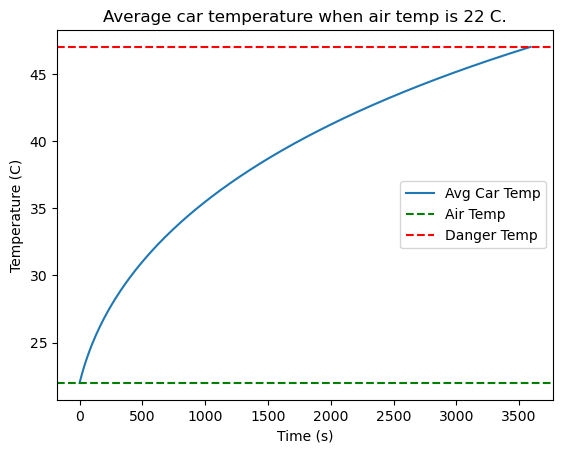

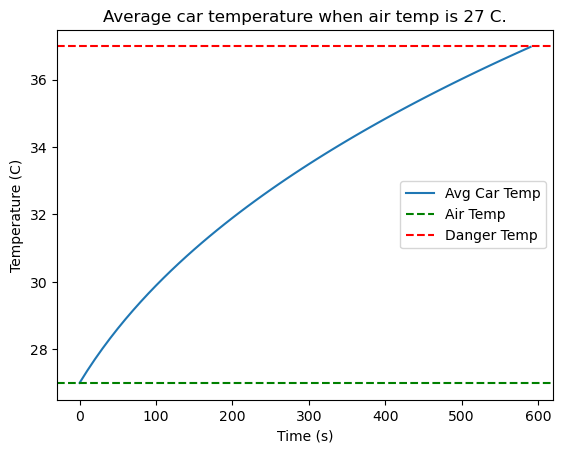

In [15]:
def plot1(A,B):
    oneHour = 3600
    airTemp = 22
    hotCarTemp = 47
    u0.fill(airTemp)
    time = np.arange(0,oneHour,10)
    
    oneHourCalc = solve_ivp(dudtFlat, t_span=[0,oneHour], y0=u0.flatten(), t_eval= time, 
                            args=[thermalDiffusivity,solarIntensity,Deltax,airTemp,A,B])
    
    avgBoxTempCalc = np.mean(oneHourCalc.y,axis=0)

    plt.plot(time,avgBoxTempCalc,label='Avg Car Temp')
    plt.axhline(y=airTemp,label='Air Temp',ls='--',color='green')
    plt.axhline(y=hotCarTemp,label='Danger Temp',ls='--',color='red')
    plt.title(f'Average car temperature when air temp is {airTemp:.0f} C.') 
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

def plot2(A,B):
    tenMin = 60*10
    airTemp = 27
    hotCarTemp = 37
    u0.fill(airTemp)
    time = np.arange(0,tenMin,10)
    
    tenMinCalc = solve_ivp(dudtFlat, t_span=[0,tenMin], y0=u0.flatten(), t_eval= time, 
                            args=[thermalDiffusivity,solarIntensity,Deltax,airTemp,A,B])
    
    avgBoxTempCalc = np.mean(tenMinCalc.y,axis=0)

    plt.plot(time,avgBoxTempCalc,label='Avg Car Temp')
    plt.axhline(y=airTemp,label='Air Temp',ls='--',color='green')
    plt.axhline(y=hotCarTemp,label='Danger Temp',ls='--',color='red')
    plt.title(f'Average car temperature when air temp is {airTemp:.0f} C.') 
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

A,B = res.x
plot1(A,B)
plot2(A,B)


## One hour calculation

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def simSystem(A,B):
    oneHour = 3600
    airTemp = 27
    eqTemp = airTemp + A*solarIntensity/B * L*W/(2*(L*W + L*H + W*H))
    u0.fill(airTemp)
    time = np.arange(0,10*oneHour,100)
    
    oneHourCalc = solve_ivp(dudtFlat, t_span=[0,10*oneHour], y0=u0.flatten(), t_eval= time, 
                            args=[thermalDiffusivity,solarIntensity,Deltax,airTemp,A,B])
    return oneHourCalc

A = 1.1176e-3
B = 6.6667e-3
longCalc = simSystem(A,B)    


In [12]:
longCalc.y

array([[ 27.        ,  27.        ,  27.        , ...,  27.03679378,
         27.03679968,  27.03680357],
       [ 27.        ,  27.        ,  27.        , ...,  27.05526742,
         27.05527056,  27.05528614],
       [ 27.        ,  27.        ,  27.        , ...,  27.07876322,
         27.07878235,  27.07877825],
       ...,
       [ 27.        ,  27.75390245,  30.55809848, ...,  45.56031108,
         45.56032158,  45.56033956],
       [ 27.        ,  34.61209219,  45.00220746, ...,  65.68216538,
         65.68217653,  65.68218334],
       [ 27.        ,  95.31376409, 120.43414519, ..., 144.36214004,
        144.36214652, 144.36215195]])

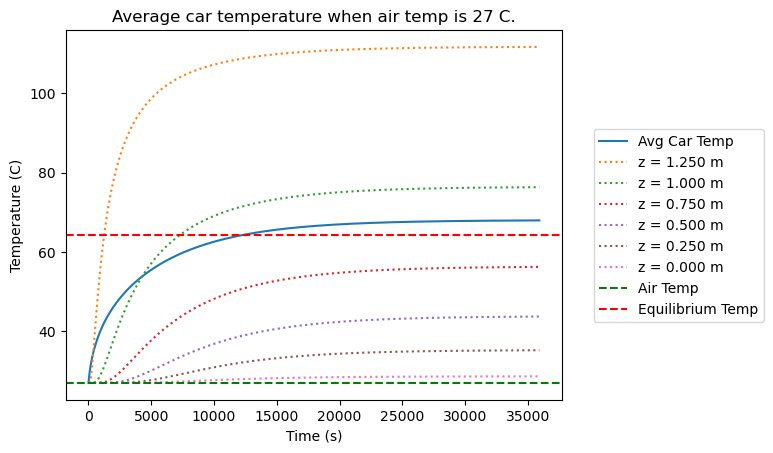

In [21]:
def plotTemperature(uflat):
    oneHour = 3600
    airTemp = 27
    eqTemp = airTemp + A*solarIntensity/B * L*W/(2*(L*W + L*H + W*H))
    time = np.arange(0,10*oneHour,100)
    avgBoxTempCalc = np.mean(uflat,axis=0)
    avgBoxTempZ = np.empty((len(time),zmax))
    
    for l in range(len(time)):
      umat = uflat[:, l].reshape((xmax,ymax,zmax))
      for k in range(zmax):
        avgBoxTempZ[l,k] = np.mean(umat[:,:,k])
      

    plt.plot(time,avgBoxTempCalc,label='Avg Car Temp')
    for k in reversed(range(0, zmax, 5)):
      zdim = k * Deltax
      labText = f'z = {zdim:.3f} m'
      plt.plot(time, avgBoxTempZ[:,k],label=labText,ls='dotted')
    plt.axhline(y=airTemp,label='Air Temp',ls='--',color='green')
    plt.axhline(y=eqTemp,label='Equilibrium Temp',ls='--',color='red')
    plt.title(f'Average car temperature when air temp is {airTemp:.0f} C.') 
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (C)')
    plt.legend(bbox_to_anchor=(1.05,0.75))
    plt.show()
    
plotTemperature(longCalc.y)